# <font color="#114b98">Conception d'une application permettant de générer un menu en fonction du régime suivi</font>



L'application génère des menus hebdomadaires personnalisés en fonction du régime suivi (végétarien, céto, etc.), avec des recettes adaptées aux préférences et restrictions de l'utilisateur. Elle simplifie la planification des repas, en proposant des idées variées pour chaque jour de la semaine.

Nous allons dans un premier temps **traiter le jeu de données afin de repérer des variables pertinentes** pour les traitements à venir et **automatiser ces traitements** pour éviter de répéter ces opérations.

## <font color="#00afe6">Sommaire</font>
[2.1. Colonnes et lignes vides / Doublons](#section_1)     
[2.2. Variables redondantes](#section_2)     
[2.3. Normalisation des pays](#section_3)     
[2.4. Les catégories de produits](#section_4)          
 


## <font color="#00afe6">2. Nettoyage des données</font>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("openfoodfacts/world-food-facts")
print("Path to dataset files:", path)


Path to dataset files: C:\Users\calvy\.cache\kagglehub\datasets\openfoodfacts\world-food-facts\versions\5


Le jeu de données téléchargé en CSV sur le site [Open Food Facts](https://world.openfoodfacts.org/) est importé dans le Notebook via la méthode `read_csv` de la librairie `pandas`

In [111]:
datas = pd.read_csv("C:\\Users\\calvy\\Downloads\\en.openfoodfacts.org.products.csv\\en.openfoodfacts.org.products.csv", 
                    sep='\t', low_memory=False)


Affichons à présent quelques lignes au hasard du dataset puis regardons sa `shape`

In [ ]:
datas.sample(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
1016926,4000470046825,http://world-en.openfoodfacts.org/product/4000...,prepperapp,1591454098,2020-06-06T14:34:58Z,1591454098,2020-06-06T14:34:58Z,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1340302,7613312053805,http://world-en.openfoodfacts.org/product/7613...,foodrepo,1548771672,2019-01-29T14:21:12Z,1578153835,2020-01-04T16:03:55Z,Grissini casarecci Olive limited edition,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208362,0074854321031,http://world-en.openfoodfacts.org/product/0074...,org-database-usda,1587660725,2020-04-23T16:52:05Z,1587660725,2020-04-23T16:52:05Z,Hulled millet,NaN,NaN,...,NaN,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
589196,2634241035828,http://world-en.openfoodfacts.org/product/2634...,kiliweb,1615717185,2021-03-14T10:19:45Z,1615717187,2021-03-14T10:19:47Z,1/2 Coppa sous vide 270gr,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350964,0696859073366,http://world-en.openfoodfacts.org/product/0696...,usda-ndb-import,1489077212,2017-03-09T16:33:32Z,1587588854,2020-04-22T20:54:14Z,"Supergirl, Soup, Black Bean & Corn",NaN,NaN,...,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print ("Le dataset compte {} lignes et {} variables".format(datas.shape[0], datas.shape[1]))

Le dataset compte 1701965 lignes et 184 variables


### <font color="#ea1c60" id="section_1">2.1. Colonnes et lignes vides / Doublons</font>
Regardons à présent les **variables qui comptent le plus de valeurs null**:

In [7]:
def null_factor(df, tx_threshold=50):
  null_rate = ((datas.isnull().sum() / datas.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  high_null_rate = null_rate[null_rate.Taux_de_Null >= tx_threshold]
  return high_null_rate

In [ ]:
full_null_rate = null_factor(datas, 100)
full_null_rate

,Variable,Taux_de_Null
0,allergens_en,100.0
1,no_nutriments,100.0
2,cities,100.0
3,ingredients_that_may_be_from_palm_oil,100.0
4,ingredients_from_palm_oil,100.0
5,additives,100.0
6,nutrition-score-uk_100g,100.0
7,water-hardness_100g,100.0


Nous allons regarder le taux de remplissage des variables graphiquement et fixer un **seuil de suppression à 30% de taux de remplissage. Nous considérons que ce qui est en dessous de 30% n'est pas utilisable et donc la colonne doit être supprimée :

C:\Users\calvy\AppData\Local\Temp\ipykernel_9860\1576561398.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")


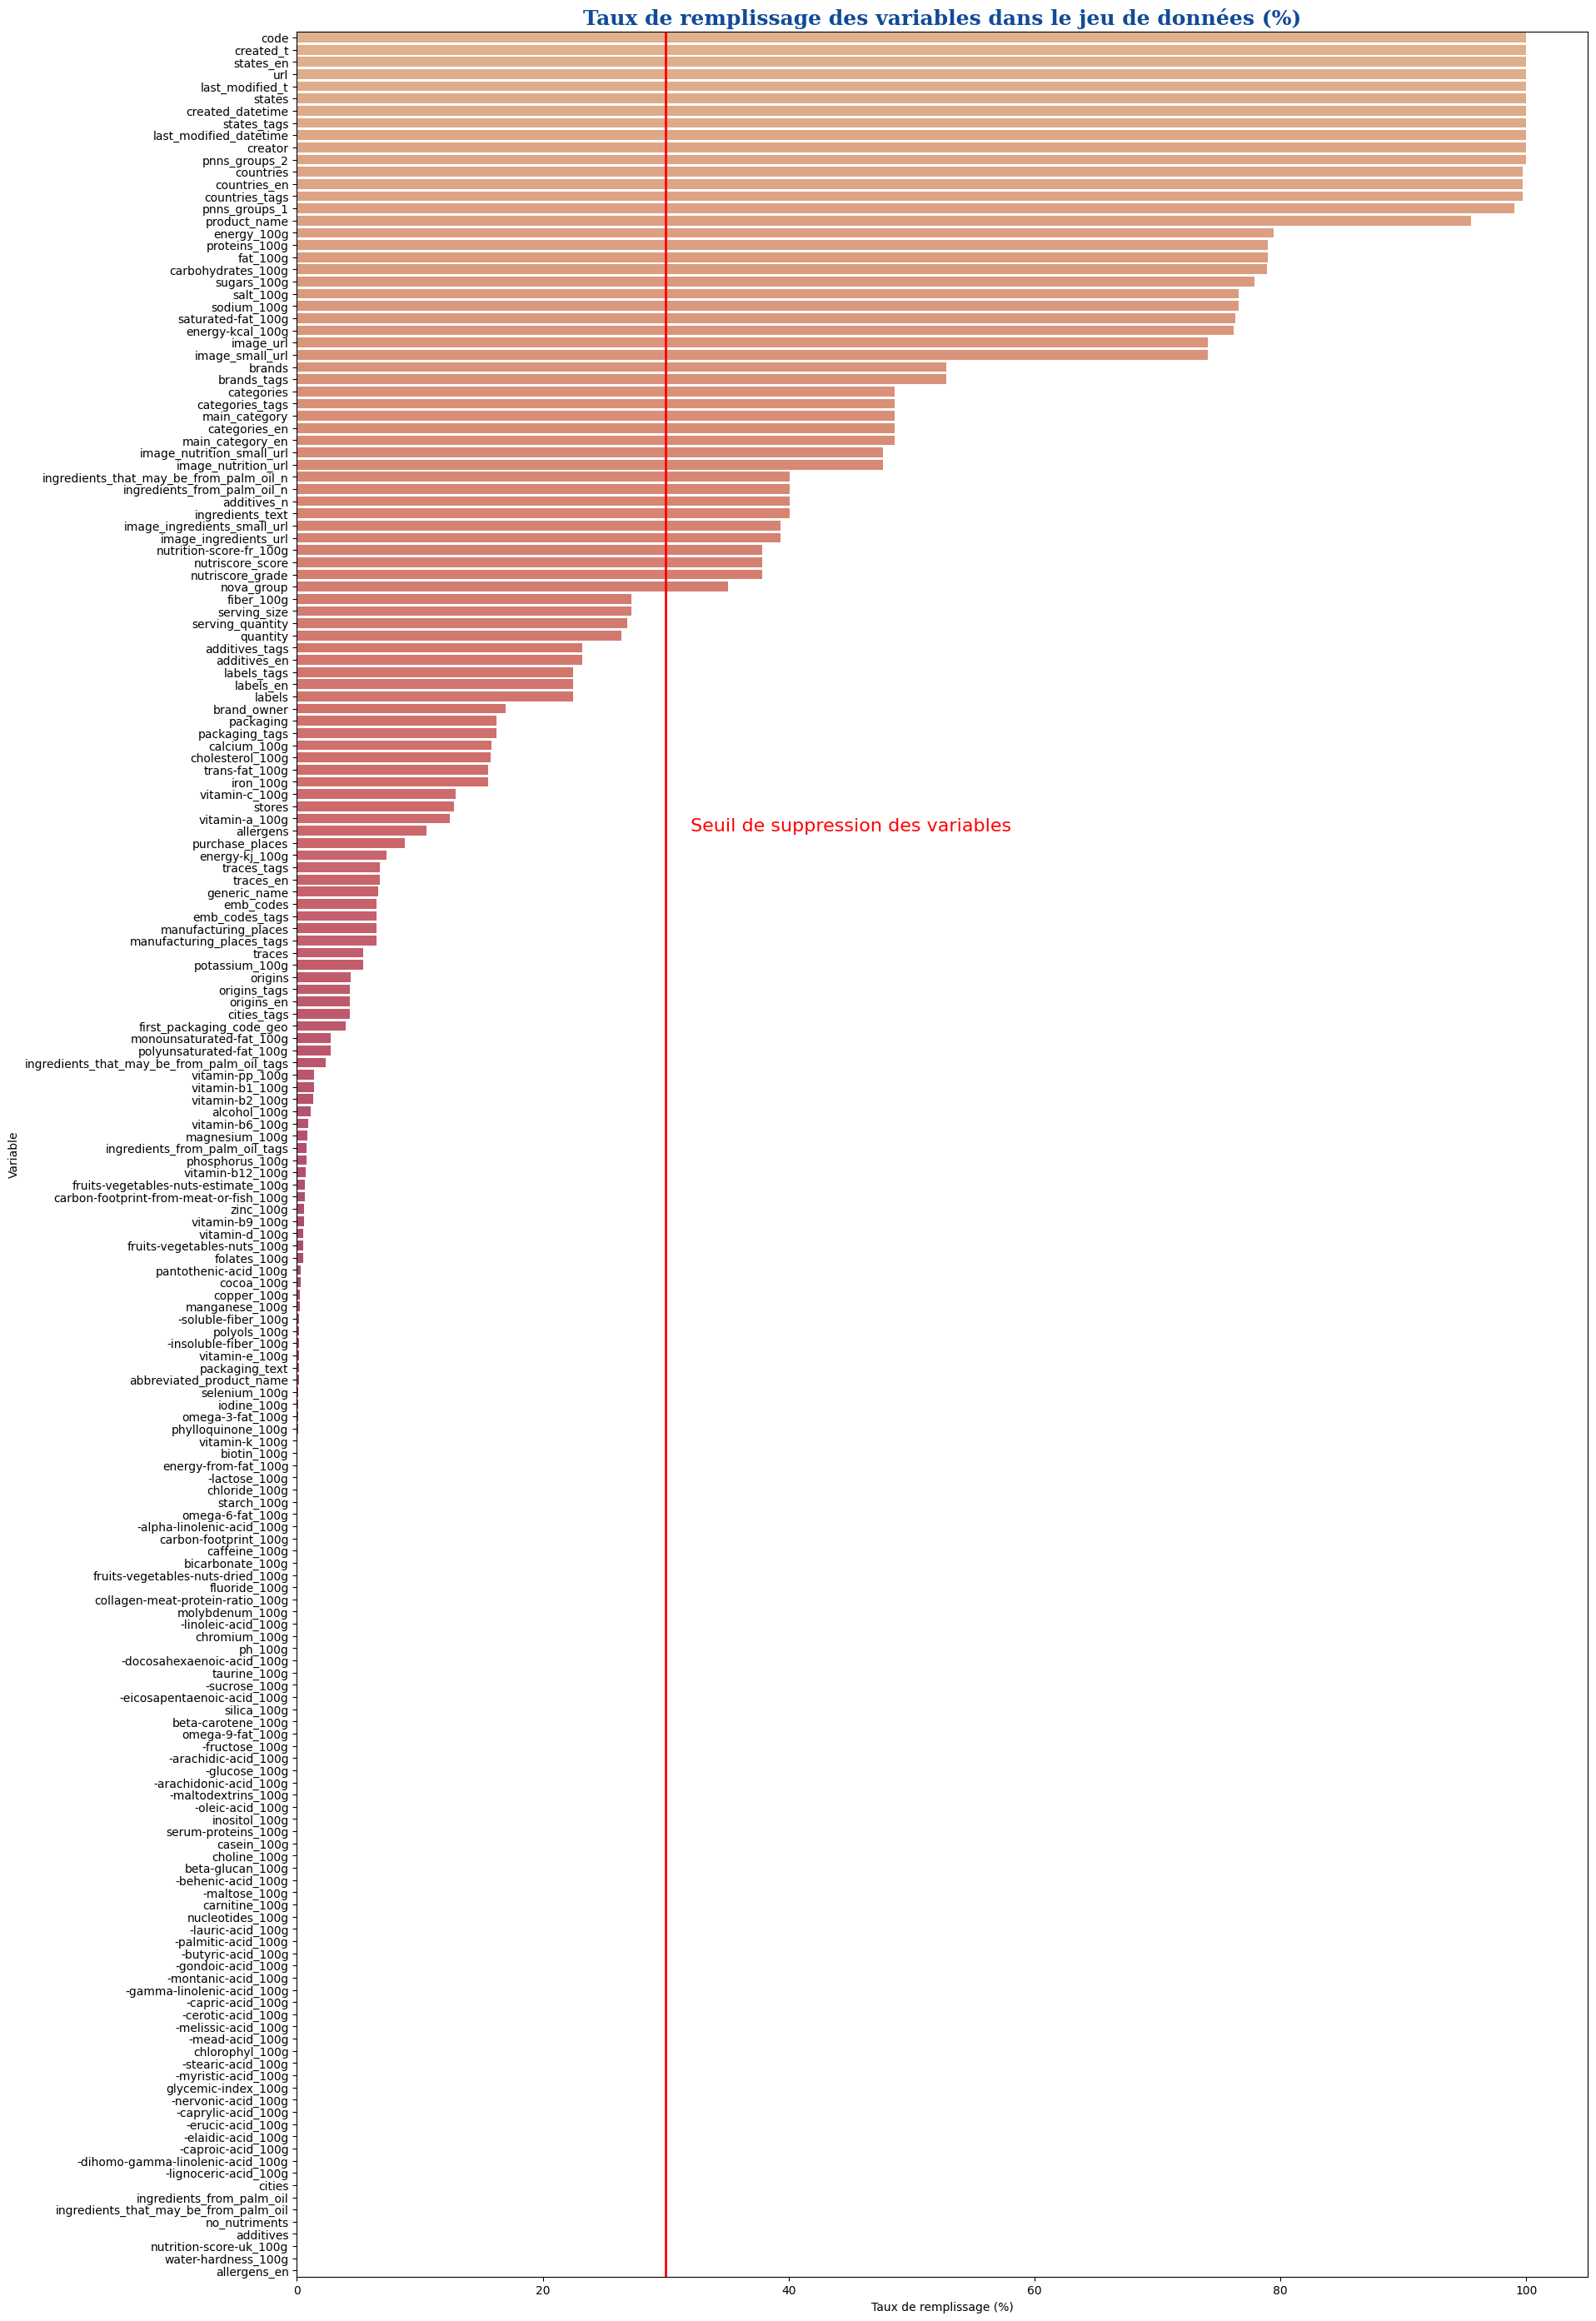

In [ ]:
filling_features = null_factor(datas, 0)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False)

#Seuil de suppression
sup_threshold = 30

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

Nous conservons toutes les colonnes qui sont supérieures à 30% de remplissage au sein du dataset.

In [ ]:
#Liste des variables à conserver
features_to_conserve = list(filling_features.loc[filling_features['Taux_de_Null']>=sup_threshold, 'Variable'].values)
#Liste des variables supprimées
deleted_features = list(filling_features.loc[filling_features['Taux_de_Null']<sup_threshold, 'Variable'].values)

#Nouveau Dataset avec les variables conservées
datas = datas[features_to_conserve].sort_values(["created_datetime","last_modified_datetime"], ascending=True)
datas.sample(5)


,code,created_t,states_en,url,last_modified_t,states,created_datetime,states_tags,last_modified_datetime,creator,...,ingredients_that_may_be_from_palm_oil_n,ingredients_from_palm_oil_n,additives_n,ingredients_text,image_ingredients_small_url,image_ingredients_url,nutrition-score-fr_100g,nutriscore_score,nutriscore_grade,nova_group
1005907,3770011355044,1561143666,"To be completed,Nutrition facts to be complete...",http://world-en.openfoodfacts.org/product/3770...,1571330299,"en:to-be-completed, en:nutrition-facts-to-be-c...",2019-06-21T19:01:06Z,"en:to-be-completed,en:nutrition-facts-to-be-co...",2019-10-17T16:38:19Z,kiliweb,...,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN
1648188,8717333848675,1520787240,"To be completed,Nutrition facts completed,Ingr...",http://world-en.openfoodfacts.org/product/8717...,1582746316,"en:to-be-completed, en:nutrition-facts-complet...",2018-03-11T16:54:00Z,"en:to-be-completed,en:nutrition-facts-complete...",2020-02-26T19:45:16Z,kiliweb,...,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN
822171,3439496404981,1520686137,"To be completed,Nutrition facts completed,Ingr...",http://world-en.openfoodfacts.org/product/3439...,1582648831,"en:to-be-completed, en:nutrition-facts-complet...",2018-03-10T12:48:57Z,"en:to-be-completed,en:nutrition-facts-complete...",2020-02-25T16:40:31Z,kiliweb,...,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN
722812,3263858780112,1518805399,"To be completed,Nutrition facts completed,Ingr...",http://world-en.openfoodfacts.org/product/3263...,1552295963,"en:to-be-completed, en:nutrition-facts-complet...",2018-02-16T18:23:19Z,"en:to-be-completed,en:nutrition-facts-complete...",2019-03-11T09:19:23Z,kiliweb,...,0.0,0.0,0.0,"ge à pâte pressée non cuite, râpé Ingrédients ...",https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN
1693234,9339929000640,1602132661,"To be completed,Nutrition facts completed,Ingr...",http://world-en.openfoodfacts.org/product/9339...,1602132664,"en:to-be-completed, en:nutrition-facts-complet...",2020-10-08T04:51:01Z,"en:to-be-completed,en:nutrition-facts-complete...",2020-10-08T04:51:04Z,kiliweb,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


155 features(colonnes) sur 184 ont un taux de valeurs nulles supérieur à 50%, ce qui représente une très grosse part de données manquantes. **La majeure partie de ces variables ne peuvent pas être recalculées** puisqu'il s'agit de mesures physico-chimiques directes sur les produits.

Il reste à présent 46 features dans notre dataset. Pour la suite des analyses, nous aurons besoin d'un minimum d'informations sur **les nutriments** des produits. Ces données sont **suffixées avec** `_100g`. Nous allons donc **conserver les lignes pour lesquelles au moins une de ces features est complétée** :

In [ ]:
# Fonction pour rechercher les colonnes contenant '_100g'
def search_componant(df, suffix='_100g'):
    componant = []
    for col in df.columns:
        if suffix in col:
            componant.append(col)
    df_subset_columns = df[componant]
    return df_subset_columns

# Filtrer les colonnes "_100g"
df_subset_nutients = search_componant(datas, '_100g')

# Remplir les valeurs manquantes des colonnes "_100g" avec 0
df_subset_nutients_filled = df_subset_nutients.fillna(0)

# Mettre à jour les données principales avec les valeurs modifiées
datas[df_subset_nutients.columns] = df_subset_nutients_filled

# Maintenant, on élimine les lignes où toutes les colonnes de "_100g" sont NaN (si nécessaire)
datas = datas[df_subset_nutients_filled.notnull().any(axis=1)]

# Suppression des doublons en fonction du code
datas.drop_duplicates(subset ="code", keep = 'last', inplace=True)

# Vérifier la forme du dataframe après modification
datas.sample(5)



,code,created_t,states_en,url,last_modified_t,states,created_datetime,states_tags,last_modified_datetime,creator,...,ingredients_that_may_be_from_palm_oil_n,ingredients_from_palm_oil_n,additives_n,ingredients_text,image_ingredients_small_url,image_ingredients_url,nutrition-score-fr_100g,nutriscore_score,nutriscore_grade,nova_group
14615,0011213252216,1489068447,"To be completed,Nutrition facts completed,Ingr...",http://world-en.openfoodfacts.org/product/0011...,1587581999,"en:to-be-completed, en:nutrition-facts-complet...",2017-03-09T14:07:27Z,"en:to-be-completed,en:nutrition-facts-complete...",2020-04-22T18:59:59Z,usda-ndb-import,...,0.0,0.0,2.0,"Popcorn, palm oil with tbhq, salt, natural and...",NaN,NaN,13.0,13.0,d,4.0
21013,0014054110097,1587649020,"To be completed,Nutrition facts completed,Ingr...",http://world-en.openfoodfacts.org/product/0014...,1587649020,"en:to-be-completed, en:nutrition-facts-complet...",2020-04-23T13:37:00Z,"en:to-be-completed,en:nutrition-facts-complete...",2020-04-23T13:37:00Z,org-database-usda,...,0.0,0.0,0.0,Orange juice.,NaN,NaN,0.0,NaN,NaN,1.0
1223459,5411205644053,1553770186,"To be completed,Nutrition facts completed,Ingr...",http://world-en.openfoodfacts.org/product/5411...,1553770912,"en:to-be-completed, en:nutrition-facts-complet...",2019-03-28T10:49:46Z,"en:to-be-completed,en:nutrition-facts-complete...",2019-03-28T11:01:52Z,kiliweb,...,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,0.0,NaN,NaN,NaN
416192,0841905080113,1614301719,"To be completed,Nutrition facts completed,Ingr...",http://world-en.openfoodfacts.org/product/0841...,1614301720,"en:to-be-completed, en:nutrition-facts-complet...",2021-02-26T01:08:39Z,"en:to-be-completed,en:nutrition-facts-complete...",2021-02-26T01:08:40Z,kiliweb,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
811145,3415587423017,1593093321,"To be completed,Nutrition facts completed,Ingr...",http://world-en.openfoodfacts.org/product/3415...,1597764876,"en:to-be-completed, en:nutrition-facts-complet...",2020-06-25T13:55:21Z,"en:to-be-completed,en:nutrition-facts-complete...",2020-08-18T15:34:36Z,kiliweb,...,1.0,0.0,1.0,"Crème fraîche (21%), cacahuètes grillées (17%)...",https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,16.0,16.0,d,4.0


In [ ]:
import pandas as pd
import re

# Fonction pour vérifier si une chaîne est du texte (en supprimant les caractères non alphabétiques)
def is_text(value):
    return isinstance(value, str) and bool(re.match("^[A-Za-zÀ-ÖØ-öø-ÿ0-9\s,.'-]*$", value))

# Filtrer et garder uniquement les lignes avec des valeurs textuelles valides dans 'product_name' et 'brands'
datas = datas[(datas["product_name"].apply(is_text)) & (datas["brands"].apply(is_text))]

# Vérifier la forme du dataframe après nettoyage
datas.shape

(701335, 46)

In [19]:
# Filtre les produits et marques non nulles, les regroupe par nom de produit et marque, puis compte le nombre de codes uniques associés à chaque combinaison. Enfin, elle trie ces résultats par ordre décroissant du nombre de codes uniques.
datas = datas[(~datas.duplicated(["product_name","brands"],keep="last"))
      | ((datas['product_name'].isnull()) & (datas['brands'].isnull()))]

Après ce second nettoyage, nous avons 1 124 703 lignes et 46 colonnes.

In [21]:
datas.shape

(701335, 46)

### <font color="#ea1c60" id="section_2">2.2. Variables redondantes</font>

Certaines variables dans le dataset sont en réalité des variables redondantes. C'est par exemple le cas des variables suffixées par `_tags` ou `_en` qui ne font que reprendre d'autres features traduites ou simplifiées.

C'est par exemple de cas des catégories produits :

In [44]:
category_columns = ['categories','categories_tags','categories_en']
datas[datas[category_columns].notnull().any(axis=1)][['product_name'] + category_columns].sample(5)

,product_name,categories,categories_tags,categories_en
1426329,Formamagio fresco,Formaggio spalmabile,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product..."
669662,Pain de mie - sans croûte - 14 tranches,"Aliments et boissons à base de végétaux, Alime...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
451272,Peanut Butter Cup,Snacks,en:snacks,Snacks
624991,Pursoup veloute 10 legumes liebig 2x1l lot fam...,"Aliments et boissons à base de végétaux, Alime...","en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo..."
726118,Petits suisse Montebourg with chocolate - Fres...,"Produits laitiers, Desserts, Desserts lactés, ...","en:dairies,en:desserts,en:dairy-desserts,en:pe...","Dairies,Desserts,Dairy desserts,Petits suisses..."


On remarque dans ces quelques exemples que les variables sont bien redondantes. Nous allons donc, lorsque la colonne suffixée `_en` existe, supprimer toutes les autres colonnes identiques non suffixées ou contenant `_tags` :

In [22]:
def search_redundant_col(df):
  redundant_columns = []
  for col in df.columns:
    if "_en" in col:
      en = col.replace('_en','')
      tags = col.replace('_en','_tags')
      print("{:<20} 'Sans suffixe' -> {} ; 'Suffixe _tags' -> {}".format(col,
                                                                        en in df.columns, tags in df.columns))
      if en in df.columns :
        redundant_columns.append(en)
      if tags in df.columns :
        redundant_columns.append(tags)

    if '_tags' in col:
      tags_2 = col.replace('_tags','')
      print("{:<20} 'Suffixe _tags' -> {} ;".format(tags_2, tags_2 in df.columns))
      if tags_2 in df.columns :
        redundant_columns.append(col)

  return redundant_columns

In [ ]:
datas.drop(search_redundant_col(datas), axis=1, inplace=True)

states_en            'Sans suffixe' -> False ; 'Suffixe _tags' -> False
countries_en         'Sans suffixe' -> False ; 'Suffixe _tags' -> False
categories_en        'Sans suffixe' -> False ; 'Suffixe _tags' -> False
main_category_en     'Sans suffixe' -> False ; 'Suffixe _tags' -> False


**Les dates également comportent une certaine redondance**. Entre les timestamp et les dates au format "yyyy-mm-dd", il est nécessaire d'en éliminer :

In [32]:
# Vérifiez les noms des colonnes
print(datas.columns)

# Si les colonnes existent sous un autre nom, ajustez ici :
# Par exemple, si 'created_t' s'appelle 'created_timestamp', modifiez en conséquence
if 'created_t' in datas.columns and 'last_modified_t' in datas.columns:
    datas['created_datetime'] = pd.to_datetime(datas['created_t'], unit='s')
    datas['last_modified_datetime'] = pd.to_datetime(datas['last_modified_t'], unit='s')
    datas = datas.drop(['created_t', 'last_modified_t'], axis=1)
else:
    print("Les colonnes 'created_t' et 'last_modified_t' sont absentes.")
datas.head(5)
datas.shape

Index(['code', 'states_en', 'url', 'created_datetime',
       'last_modified_datetime', 'creator', 'pnns_groups_2', 'countries_en',
       'pnns_groups_1', 'product_name', 'energy_100g', 'proteins_100g',
       'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g',
       'sodium_100g', 'saturated-fat_100g', 'energy-kcal_100g', 'image_url',
       'image_small_url', 'brands', 'categories_en', 'main_category_en',
       'image_nutrition_small_url', 'image_nutrition_url',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_from_palm_oil_n', 'additives_n', 'ingredients_text',
       'image_ingredients_small_url', 'image_ingredients_url',
       'nutrition-score-fr_100g', 'nutriscore_score', 'nutriscore_grade',
       'nova_group'],
      dtype='object')
Les colonnes 'created_t' et 'last_modified_t' sont absentes.


(701335, 36)

A présent, notre dataset compte 36 variables qui ne contienent plus de redondance et 701335 lignes. Nous allons maintenant nous intéresser à une variable importante : le pays. La colonne pays est une colonne critique et elle doit être normalisée

### <font color="#ea1c60" id="section_3">2.3. Normalisation des pays</font>

Regardons tout d'abord le nombre de pays représentés.

In [33]:
countries = datas.groupby(by="countries_en").nunique()

In [34]:
countries[['code']].head()

,code
countries_en,
Afghanistan,3
"Afghanistan,Belgium,France",2
"Afghanistan,France",99
"Afghanistan,France,French Guiana",1
"Afghanistan,France,Germany",1


Plusieurs pays sont regroupés dans la même variable, nous allons devoir effectuer un split du texte pour visualiser tout nos pays. La fonction split_words extrait tous les mots uniques d'une colonne spécifiée d'un DataFrame pandas, en les séparant par des virgules et en ignorant les valeurs manquantes.

In [35]:
def split_words(df, column='countries_en'):
    # Initialiser un ensemble pour stocker les mots uniques
    list_words = set()
    
    # Parcourir chaque entrée de la colonne spécifiée du DataFrame
    for word in df[column].str.split(','):
        # Si l'entrée est un flottant (NaN), passer à l'itération suivante
        if isinstance(word, float):
            continue
        # Ajouter les mots de l'entrée actuelle à l'ensemble list_words
        list_words = set().union(word, list_words)
    
    # Retourner la liste des mots uniques
    return list(list_words)


In [36]:
#Liste contenant tous les pays du jeu de données (bons ou mauvais)
list_countries = split_words(datas, 'countries_en')

In [37]:
print("Nombre de pays représentés : {}".format(len(list_countries)))

Nombre de pays représentés : 536


Nous allons charger une **base de données des pays, en Anglais**, pour déterminer les pays qui ne matchent pas *(mauvaise orthographe ou autre)*. En effet, il faut télécharger un dataset contenant les pays du monde entier dans format normalisé afin de bien parser les données du dataset OpenFoodFacts

In [38]:
df_countries = pd.read_csv("countries-en.csv",
                        sep=",", header=None, index_col = 0).rename(columns={0:"index", 1:"country_id", 2:"country_code_2", 3:"country_code_3", 4:"country_fr", 5:"country_en"})
df_countries.head()

,country_id,country_code_2,country_code_3,country_fr,country_en
0,,,,,
1,4,AF,AFG,Afghanistan,Afghanistan
2,8,AL,ALB,Albanie,Albania
3,10,AQ,ATA,Antarctique,Antarctica
4,12,DZ,DZA,Algérie,Algeria
5,16,AS,ASM,Samoa Américaines,American Samoa


In [39]:
df_countries = pd.merge(pd.DataFrame(list_countries, columns=["countries_dataset"]),df_countries, how="left",
         left_on="countries_dataset", right_on="country_en")

In [40]:
false_country_list = list(df_countries[df_countries.isnull().sum(axis=1)>0].countries_dataset)
false_country_list[0:15]

['United-states-english',
 'France-francais',
 'Asia-pacific',
 'fr:q',
 'Finland-suomi',
 'Belgio',
 'es:408889642364',
 'Swaziland-english',
 'Vereinigte-staaten-von-amerika',
 'Israel-עברית',
 'Yugoslavia',
 'Frankreich',
 'Portugal-portugues',
 'es:santona',
 'fr:francija']

puis nous allons **supprimer ces pays "fantômes" de la base de données** :

In [41]:
for index, countries in datas['countries_en'].str.split(',').items():
  if isinstance(countries, float):
    continue
  country_name = []
  found = False
  for country in countries:
    if country in false_country_list:
      found = True
    else:
      country_name.append(country)
  if found:
    datas.loc[index, 'countries_en'] = ','.join(country_name)

In [42]:
print("Nouveau nombre de pays représentés : {}".format(len(split_words(datas, 'countries_en'))))

Nouveau nombre de pays représentés : 182


Le nombre de pays représenté est à présent plus cohérent et la perte d'informations est limitée. Il nous reste à présent à **compléter les valeurs nulles pour cette variable**.

In [43]:
datas['countries_en'] = np.where((datas['countries_en'].isnull()==True), "unknown",
                                 np.where(datas['countries_en'] == "", "unknown", datas['countries_en']))

Nous pouvons également regarder quels sont les **pays les plus représentés** :

In [48]:
def top_words(df, column="countries_en", nb_top=10):
    count_keyword = dict()
    for index, col in df[column].items():  # Utilisation de .items() au lieu de .iteritems()
        if isinstance(col, float):
            continue
        for word in col.split(','):
            word = word.strip()  # Nettoie les espaces autour du mot
            if word in count_keyword.keys():
                count_keyword[word] += 1
            else:
                count_keyword[word] = 1

    keyword_top = []
    for k, v in count_keyword.items():
        keyword_top.append([k, v])
    keyword_top.sort(key=lambda x: x[1], reverse=True)

    return keyword_top[:nb_top]

# Appel de la fonction et création du DataFrame
df_top_countries = pd.DataFrame(top_words(df=datas, column="countries_en", nb_top=10),
                                columns=["Keyword", "count"])
df_top_countries


,Keyword,count
0,France,331553
1,United States,147567
2,Spain,89088
3,Germany,48245
4,Switzerland,28619
5,Belgium,25532
6,United Kingdom,18818
7,Italy,13456
8,Canada,6697
9,Mexico,4563


In [49]:
print(datas.columns)

Index(['code', 'states_en', 'url', 'created_datetime',
       'last_modified_datetime', 'creator', 'pnns_groups_2', 'countries_en',
       'pnns_groups_1', 'product_name', 'energy_100g', 'proteins_100g',
       'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'salt_100g',
       'sodium_100g', 'saturated-fat_100g', 'energy-kcal_100g', 'image_url',
       'image_small_url', 'brands', 'categories_en', 'main_category_en',
       'image_nutrition_small_url', 'image_nutrition_url',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_from_palm_oil_n', 'additives_n', 'ingredients_text',
       'image_ingredients_small_url', 'image_ingredients_url',
       'nutrition-score-fr_100g', 'nutriscore_score', 'nutriscore_grade',
       'nova_group'],
      dtype='object')


**La France et les Etats-Unis sont massivement représentés** dans le Dataset. Le 10ème Pays représenté en terme de volume ne compte plus que 4536 entrées - soit 73 fois moins que le 1er. Cette différence devra être prise en compte dans les futurs modèles développés.

### <font color="#ea1c60" id="section_4">2.4. Les catégories de produits</font>

Intéressons nous à présent à la catégorisation des produits. 4 variables représentent cette catégorisation de manière plus ou moins précise : `categories_en`, `main_category_en`, `pnns_groups_1`, `pnns_groups_2`.

In [ ]:
datas[['categories_en','pnns_groups_1','pnns_groups_2','main_category_en',]].sample(10)

,categories_en,pnns_groups_1,pnns_groups_2,main_category_en
369858,"Plant-based foods and beverages,Plant-based fo...",Cereals and potatoes,Cereals,Cereals and their products
912019,"Snacks,Sweet snacks,Confectioneries,Candies",Sugary snacks,Sweets,Candies
940759,NaN,unknown,unknown,NaN
1313522,Vinegars,Fat and sauces,Dressings and sauces,Vinegars
192456,NaN,unknown,unknown,NaN
49676,"Biscuits and cakes,Cakes",Sugary snacks,Biscuits and cakes,Cakes
470414,NaN,unknown,unknown,NaN
670373,"Fish and meat and eggs,Foies gras,Foies gras f...",Salty snacks,Salty and fatty products,Whole foies gras
1408161,"Plant-based foods and beverages,Plant-based fo...",Cereals and potatoes,Cereals,Pastas
1128461,NaN,unknown,unknown,NaN


Nous allons regarder le **nombre total de catégories représentées** :

In [60]:
categories = split_words(df = datas, column = 'categories_en')
print("{} catégories sont représentées dans le jeu de données.".format(len(categories)))

26164 catégories sont représentées dans le jeu de données.


Ici également, nous allons regarder les **catégories les plus représentées**, après avoir remplacé les valeurs nulles et complété les valeurs inconnues des pnns avec la catégorie principale :

In [63]:
# Remplacer les valeurs manquantes ou vides dans la colonne 'categories_en' par "unknown"
datas['categories_en'] = np.where(
    (datas['categories_en'].isnull() == True),  # Si la valeur est manquante (NaN)
    "unknown",  # Remplacer par "unknown"
    np.where(  # Sinon, on vérifie si la valeur est une chaîne vide
        datas['categories_en'] == "",  # Si la valeur est une chaîne vide
        "unknown",  # Remplacer par "unknown"
        datas['categories_en']  # Sinon, garder la valeur d'origine
    )
)

# Remplacer les valeurs manquantes ou vides dans la colonne 'main_category_en' par "unknown"
datas['main_category_en'] = np.where(
    (datas['main_category_en'].isnull() == True),  # Si la valeur est manquante (NaN)
    "unknown",  # Remplacer par "unknown"
    np.where(  # Sinon, on vérifie si la valeur est une chaîne vide
        datas['main_category_en'] == "",  # Si la valeur est une chaîne vide
        "unknown",  # Remplacer par "unknown"
        datas['main_category_en']  # Sinon, garder la valeur d'origine
    )
)

# Remplacer les valeurs manquantes ou vides dans la colonne 'pnns_groups_1' par "unknown"
datas['pnns_groups_1'] = np.where(
    (datas['pnns_groups_1'].isnull() == True),  # Si la valeur est manquante (NaN)
    "unknown",  # Remplacer par "unknown"
    np.where(  # Sinon, on vérifie si la valeur est une chaîne vide
        datas['pnns_groups_1'] == "",  # Si la valeur est une chaîne vide
        "unknown",  # Remplacer par "unknown"
        datas['pnns_groups_1']  # Sinon, garder la valeur d'origine
    )
)

# Remplacer les valeurs manquantes ou vides dans la colonne 'pnns_groups_2' par "unknown"
datas['pnns_groups_2'] = np.where(
    (datas['pnns_groups_2'].isnull() == True),  # Si la valeur est manquante (NaN)
    "unknown",  # Remplacer par "unknown"
    np.where(  # Sinon, on vérifie si la valeur est une chaîne vide
        datas['pnns_groups_2'] == "",  # Si la valeur est une chaîne vide
        "unknown",  # Remplacer par "unknown"
        datas['pnns_groups_2']  # Sinon, garder la valeur d'origine
    )
)

In [ ]:
df_top_categories = pd.DataFrame(top_words(df=datas, column="categories_en", nb_top=10),
                                 columns=["Keyword","count"])
df_top_categories

,Keyword,count
0,unknown,236353
1,Plant-based foods and beverages,142612
2,Plant-based foods,123967
3,Snacks,82115
4,Sweet snacks,58058
5,Beverages,56429
6,Cereals and potatoes,45442
7,Dairies,45188
8,Fruits and vegetables based foods,38416
9,Groceries,36315


Passons à présent aux variables `pnns_groups_1` et `pnns_groups_2` qui nous apporteront des informations plus précises :

In [65]:
pnns_groups_1 = split_words(df = datas, column = 'pnns_groups_1')
pnns_groups_2 = split_words(df = datas, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

14 catégories sont représentées dans la variable pnns_group_1.
46 catégories sont représentées dans la variable pnns_group_2.


In [66]:
pnns_groups_1

['sugary-snacks',
 'Sugary snacks',
 'fruits-and-vegetables',
 'cereals-and-potatoes',
 'Fruits and vegetables',
 'Composite foods',
 'Fat and sauces',
 'unknown',
 'salty-snacks',
 'Beverages',
 'Milk and dairy products',
 'Fish Meat Eggs',
 'Salty snacks',
 'Cereals and potatoes']

On voit ici que certaines catégories sont présentes plusieurs fois mais orthographiées différement :
- 'Cereals and potatoes' et 'cereals-and-potatoes'
- 'fruits-and-vegetables' et 'Fruits and vegetables'
- ...

Nous allons donc corriger le problème en passant le texte en miniscule et en remplaçant les caractères spéciaux par un espace :

In [67]:
datas["pnns_groups_1"] = datas["pnns_groups_1"].str.lower().str.replace('-', ' ')

In [68]:
pnns_groups_1 = split_words(df = datas, column = 'pnns_groups_1')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print(pnns_groups_1)

10 catégories sont représentées dans la variable pnns_group_1.
['unknown', 'sugary snacks', 'beverages', 'cereals and potatoes', 'salty snacks', 'milk and dairy products', 'fat and sauces', 'fish meat eggs', 'fruits and vegetables', 'composite foods']


In [69]:
pnns_groups_2

['Fats',
 'Dried fruits',
 'Biscuits and cakes',
 'Cereals',
 'Fish and seafood',
 'Sandwiches',
 'Offals',
 'Dairy desserts',
 'cereals',
 'Alcoholic beverages',
 'Meat',
 'Artificially sweetened beverages',
 'Fruit juices',
 'Sweets',
 'nuts',
 'Nuts',
 'Cheese',
 'Dressings and sauces',
 'Teas and herbal teas and coffees',
 'Legumes',
 'Fruits',
 'Milk and yogurt',
 'Eggs',
 'Sweetened beverages',
 'fruits',
 'Ice cream',
 'Pizza pies and quiches',
 'Fruit nectars',
 'Pizza pies and quiche',
 'unknown',
 'Plant-based milk substitutes',
 'Chocolate products',
 'Soups',
 'Breakfast cereals',
 'pastries',
 'Potatoes',
 'Salty and fatty products',
 'Bread',
 'Vegetables',
 'Waters and flavored waters',
 'Appetizers',
 'legumes',
 'Unsweetened beverages',
 'Processed meat',
 'One-dish meals',
 'vegetables']

In [ ]:
# Convertir toutes les valeurs dans la colonne 'pnns_groups_2' en minuscules
datas["pnns_groups_2"] = datas["pnns_groups_2"].str.lower()  # Convertit tous les mots en minuscules

# Remplacer tous les tirets par des espaces dans la colonne 'pnns_groups_2'
datas["pnns_groups_2"] = datas["pnns_groups_2"].str.replace('-', ' ')  # Remplace les tirets par des espaces

# Remplacer la chaîne 'pizza pies and quiche' par 'pizza pies and quiches' dans la colonne 'pnns_groups_2'
datas["pnns_groups_2"] = datas["pnns_groups_2"].replace('pizza pies and quiche','pizza pies and quiches')  # Correction d'un nom de groupe spécifique

# Utilisation de la fonction 'split_words' pour séparer les valeurs dans la colonne 'pnns_groups_2'
pnns_groups_2 = split_words(df = datas, column = 'pnns_groups_2')  # Sépare les valeurs de la colonne en mots (supposé être une fonction définie ailleurs)

# Affichage du nombre de catégories uniques dans la variable 'pnns_groups_2'
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))  # Affiche le nombre de catégories uniques


40 catégories sont représentées dans la variable pnns_group_2.


In [ ]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 701335 entries, 943812 to 125945
Data columns (total 36 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   code                                     701335 non-null  object        
 1   states_en                                701335 non-null  object        
 2   url                                      701335 non-null  object        
 3   created_datetime                         701335 non-null  datetime64[ns]
 4   last_modified_datetime                   701335 non-null  datetime64[ns]
 5   creator                                  701332 non-null  object        
 6   pnns_groups_2                            701335 non-null  object        
 7   countries_en                             701335 non-null  object        
 8   pnns_groups_1                            701335 non-null  object        
 9   product_name              

### <font color="#ea1c60" id="section_5">1.5. Compléter les valeurs manquantes ou aberrantes</font>

Le jeu de données est nettoyé mais comme le montre les informations ci-dessus, il reste un grand nombre de valeurs manquantes qu'il va falloir compléter mais également des outliers à identifier. Les valeurs outliers sont des valeurs aberrantes. Cela signifie des valeurs beaucoup trop elevées par rapport aux autres valeurs. 

Regardons dans un premier temps une rapide description du Dataset :

In [75]:
datas.describe()

,created_datetime,last_modified_datetime,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,sugars_100g,salt_100g,sodium_100g,saturated-fat_100g,energy-kcal_100g,ingredients_that_may_be_from_palm_oil_n,ingredients_from_palm_oil_n,additives_n,nutrition-score-fr_100g,nutriscore_score,nova_group
count,701335,701335,7.013350e+05,701335.000000,701335.000000,701335.000000,701335.000000,701335.000000,701335.000000,7.013350e+05,7.013350e+05,407259.000000,407259.000000,407259.000000,701335.000000,365517.000000,351187.000000
mean,2018-05-06 07:01:08.412607232,2020-03-10 03:24:19.557165824,5.186650e+07,7.003321,12.725175,26.075968,11.793578,2.128636,0.851459,1.837638e+01,1.239638e+07,0.076499,0.027118,1.858414,4.683504,8.986463,3.411570
min,2012-01-31 14:43:58,2012-04-08 08:12:35,0.000000e+00,-500.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-15.000000,-15.000000,1.000000
25%,2017-03-09 17:05:40,2020-01-11 12:24:43,1.840000e+02,0.000000,0.000000,0.700000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
50%,2018-04-08 19:41:56,2020-04-22 23:00:18,8.370000e+02,3.810000,3.220000,11.000000,2.600000,0.200000,0.080000,7.000000e-01,1.730000e+02,0.000000,0.000000,1.000000,0.000000,9.000000,4.000000
75%,2019-08-22 19:13:51,2020-11-18 19:15:17,1.577000e+03,9.620000,17.100000,50.000000,14.000000,1.100000,0.440000,5.000000e+00,3.690000e+02,0.000000,0.000000,3.000000,10.000000,16.000000,4.000000
max,2021-03-28 22:57:26,2021-03-29 00:47:29,3.637509e+13,173000.000000,999999.000000,762939.000000,6880.000000,79007.000000,31602.800000,9.999999e+06,8.693855e+12,6.000000,3.000000,32.000000,40.000000,40.000000,4.000000
std,NaN,NaN,4.343515e+10,206.826764,1199.151743,922.108433,20.824953,148.515570,59.404563,1.194093e+04,1.038125e+10,0.323451,0.164560,2.710467,7.852292,8.924055,0.968298


On remarque déjà que les valeurs minimum et maximum de **certaines variables** (comme les nutriments ou la valeur energetique) **peuvent contenir des valeurs aberrantes**, ce qui impacte également l'écart-type et donc la variance.

In [76]:
datas[datas['energy_100g'] == datas['energy_100g'].max()]

,code,states_en,url,created_datetime,last_modified_datetime,creator,pnns_groups_2,countries_en,pnns_groups_1,product_name,...,ingredients_that_may_be_from_palm_oil_n,ingredients_from_palm_oil_n,additives_n,ingredients_text,image_ingredients_small_url,image_ingredients_url,nutrition-score-fr_100g,nutriscore_score,nutriscore_grade,nova_group
1627028,8693855001005,"To be completed,Nutrition facts completed,Ingr...",http://world-en.openfoodfacts.org/product/8693...,2020-03-11 19:45:23,2020-03-11 19:52:19,halal-app-chakib,unknown,Iraq,unknown,realmadrid real,...,NaN,NaN,NaN,NaN,https://static.openfoodfacts.org/images/produc...,https://static.openfoodfacts.org/images/produc...,0.0,NaN,NaN,NaN


Ici, ce produit qui possède la plus grande valeur energétique n'est quasi pas complété. Il manque le nom du produit, les catégories et toutes les valeurs nutritionnelles. Nous allons **supprimer tous les produits qui n'ont ni nom, ni catégorie** et qui ne pourront donc être clairement identifiés.

In [77]:
datas_cleaned = datas[~((datas.product_name.isnull())
                        & ((datas.pnns_groups_1 == "unknown")
                           | (datas.main_category_en == "unknown")))]

In [78]:
datas_cleaned[((datas_cleaned.pnns_groups_1 == "unknown") & (datas_cleaned.main_category_en == "unknown") &
              (datas_cleaned.pnns_groups_2 == "unknown") & (datas_cleaned.categories_en == "unknown"))].shape[0]

236353

Il reste tout de même **236353 produits qui ne contiennent aucune indication de catégorie**.

Afin de pouvoir calculer des indicateurs corrects, nous allons remplacer par des valeurs nulles tous les max et min aberrants *(0, -1 ou 999999...)* :

In [79]:
#On repère les numerical_features
numerical_features = list(datas_cleaned.select_dtypes(include=["float64","int64"]).columns)
#On supprime les nutriscores qui eux peuvent être négatifs
numerical_features.remove('nutriscore_score')
numerical_features.remove('nutrition-score-fr_100g')
numerical_features.remove('ingredients_that_may_be_from_palm_oil_n')
numerical_features.remove('ingredients_from_palm_oil_n')
numerical_features.remove('nova_group')

In [83]:
#On supprime les lignes dont toutes les numerical_features sont à 0 ou nulles
datas_cleaned = datas_cleaned.loc[~((datas_cleaned[numerical_features]==0) | (datas_cleaned[numerical_features].isnull())).all(axis=1)]

In [88]:
#On supprime les lignes contenant des valeurs négatives et des max aberrants
datas_cleaned = datas_cleaned[~(datas_cleaned[numerical_features] < 0).any(axis=1)]
datas_cleaned = datas_cleaned[~(datas_cleaned[numerical_features].isin([999999,9999999])).any(axis=1)]
for col in datas_cleaned.columns:
    print(col)

code
states_en
url
created_datetime
last_modified_datetime
creator
pnns_groups_2
countries_en
pnns_groups_1
product_name
energy_100g
proteins_100g
fat_100g
carbohydrates_100g
sugars_100g
salt_100g
sodium_100g
saturated-fat_100g
energy-kcal_100g
image_url
image_small_url
brands
categories_en
main_category_en
image_nutrition_small_url
image_nutrition_url
ingredients_that_may_be_from_palm_oil_n
ingredients_from_palm_oil_n
additives_n
ingredients_text
image_ingredients_small_url
image_ingredients_url
nutrition-score-fr_100g
nutriscore_score
nutriscore_grade
nova_group


Les variables suffixées avec `_100g` nous indiquent la quantité de nutriments pour 100 grammes de produit. Les valeurs renseignées ne peuvent donc logiquement pas excéder 100. Nous allons donc **supprimer les lignes dont au moins 1 des variables de nutriments est supérieur au seuil**. Ici, nous fixons le seuil à 100 :

In [89]:
g_per_100g_features = ['proteins_100g','fat_100g','carbohydrates_100g','sugars_100g','salt_100g',
                       'sodium_100g','saturated-fat_100g']
datas_cleaned = datas_cleaned[~(datas_cleaned[g_per_100g_features] > 100).any(axis=1)]

D'autre part, les valeurs de `saturated-fat_100g` ne peuvent pas être supérieurs à `fat_100g`, de même pour les valeurs de `sodium_100g` qui ne peuvent pas être supérieurs à `salt_100g`.     
Nous allons donc supprimer les lignes qui remplissent ces conditions :

In [90]:
datas_cleaned = datas_cleaned[~((datas_cleaned['saturated-fat_100g'] > datas_cleaned['fat_100g'])
                                | (datas_cleaned['sodium_100g'] > datas_cleaned['salt_100g']))]

Enfin, les densité d'energie maximales pour 100g sont de 3700 kJ/100g *(source [Wikipedia](https://en.wikipedia.org/wiki/Food_energy))*. Nous allons donc supprimer toutes les lignes dont la variable `energy_100g` est supérieur à 3700 *(ou 900 kcal/100g)*.

In [91]:
datas_cleaned = datas_cleaned[~((datas_cleaned['energy_100g'] > 3700)
                                | (datas_cleaned['energy-kcal_100g'] > 900))]

In [98]:
datas_cleaned.shape

(595557, 36)

In [99]:
datas_cleaned.describe()

,created_datetime,last_modified_datetime,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,sugars_100g,salt_100g,sodium_100g,saturated-fat_100g,energy-kcal_100g,ingredients_that_may_be_from_palm_oil_n,ingredients_from_palm_oil_n,additives_n,nutrition-score-fr_100g,nutriscore_score,nova_group
count,595557,595557,595557.000000,595557.000000,595557.000000,595557.000000,595557.000000,595557.000000,595557.000000,595557.000000,595557.000000,379075.000000,379075.000000,379075.000000,595557.000000,358902.000000,332036.000000
mean,2018-03-31 11:13:50.220317952,2020-03-19 15:13:44.519236352,1097.869329,7.844195,12.606600,28.862197,13.667185,1.290041,0.516004,4.621605,246.102078,0.078436,0.028482,1.899281,5.410854,8.978696,3.467964
min,2012-01-31 14:43:58,2012-04-08 08:12:35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000,-15.000000,1.000000
25%,2017-03-09 16:22:35,2020-01-26 15:42:50,392.000000,1.100000,0.500000,4.000000,0.700000,0.036000,0.014400,0.010000,67.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
50%,2018-02-17 12:50:30,2020-04-23 07:21:28,1046.000000,5.400000,5.800000,16.000000,3.800000,0.450000,0.180000,1.400000,232.000000,0.000000,0.000000,1.000000,0.000000,9.000000,4.000000
75%,2019-07-11 08:53:26,2020-11-17 16:46:04,1645.000000,11.000000,20.000000,54.200000,19.000000,1.270000,0.508000,6.250000,387.000000,0.000000,0.000000,3.000000,12.000000,16.000000,4.000000
max,2021-03-28 21:25:08,2021-03-29 00:47:29,3700.000000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,900.000000,6.000000,3.000000,14.000000,40.000000,40.000000,4.000000
std,NaN,NaN,778.013035,9.103899,16.388324,28.252655,19.863595,5.016847,2.006729,7.353862,191.601017,0.324964,0.168474,2.508679,8.203757,8.924396,0.919027


In [104]:
datas_cleaned.isnull().sum().sort_values(ascending=False)

image_ingredients_url                      270664
image_ingredients_small_url                270664
nova_group                                 263521
image_nutrition_small_url                  258067
image_nutrition_url                        258067
nutriscore_grade                           236655
nutriscore_score                           236655
ingredients_text                           216483
ingredients_from_palm_oil_n                216482
ingredients_that_may_be_from_palm_oil_n    216482
additives_n                                216482
image_url                                  153852
image_small_url                            153852
creator                                         2
nutrition-score-fr_100g                         0
main_category_en                                0
categories_en                                   0
brands                                          0
code                                            0
states_en                                       0


Les variables sont à présent filtrées et les données nettoyées et complétées. Nous allons sauvegarder le dataset cleaned pour l'utiliser à présent dans nos **analyses exploratoires**.

In [106]:
datas_cleaned.set_index("code").to_csv("cleaned_openfoodfacts.csv", sep='\t')